In [1]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import seaborn as sns
import ot
import ot.plot
import pandas as pd

In [2]:
import sys
sys.path.append('../code/')
from generate_data import make_data_1d
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from utils import kernel
from linear_solver import UOT_W,UOT_MMD,UOT_KL

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
def make_data_1d(expe,n_samples,device='cpu'):        
    if expe=="renormalization1":
        xs=np.concatenate((np.random.normal(-10, 1, 20*n_samples),np.random.normal(0, 1, 20*n_samples)))
        xt=np.random.normal(-10, 1, 20*n_samples)

    if expe=="renormalization2":
        xs=np.concatenate((np.random.normal(-10, 1, 20*n_samples),np.random.normal(20, 1, 20*n_samples)))
        xt=np.random.normal(-10, 1, 20*n_samples)
    
    elif expe=="outlier":
        xs=np.random.normal(1, 1, 3*n_samples)
        xt=np.concatenate((np.random.normal(10, 1, 3*n_samples),np.random.normal(-10, .05, int(n_samples/30))))
        
    elif expe=="noise":
        xs=np.random.normal(-10, .7, 2*n_samples)
        xt=np.concatenate((np.random.normal(0, .7, n_samples),np.random.normal(10, .7, n_samples)))  

    elif expe=="death_birth":
        #xs=np.concatenate((np.random.normal(0, 1, 5*n_samples),np.random.normal(5, 1, 3*n_samples)))
        #xt=np.concatenate((np.random.normal(-10, 1, 4*n_samples),np.random.normal(0, 1, 2*n_samples),np.random.normal(5, 1, 5*n_samples)))
        xs=np.concatenate((np.random.normal(0, 1, 5*n_samples),np.random.normal(10, 1, 3*n_samples)))
        xt=np.concatenate((np.random.normal(-12, 1, 4*n_samples),np.random.normal(0, 1, 2*n_samples),np.random.normal(10, 1, 5*n_samples)))        
    
    X = torch.from_numpy(xs).to(device)
    Y = torch.from_numpy(xt).to(device)
    X=X.float()
    Y=Y.float()
    return X,Y

# Case 1 : Outliers

99 100


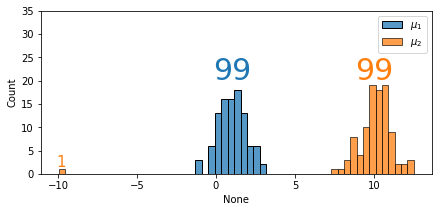

In [5]:
np.random.seed(1)
X,Y=make_data_1d("outlier",33)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
fig, ax = pl.subplots(figsize=(7,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=.5))
pl.text(1,22, "99",c="C0",alpha=1,ha="center",va="center",fontsize = 30)
pl.text(10,22, "99",c="C1",alpha=1,ha="center",va="center",fontsize = 30)
pl.text(-9.8, 2.5, "1",c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.ylim(0,35)
pl.legend()

In [6]:
lam=[10,25,200]
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(4.5270)
tensor(23.3594)
tensor(81.3070)


/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [7]:
wKL1=[]
wKL2=[]
wKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KL[i]),torch.sum(pi2_KL[i][:99]),torch.sum(pi2_KL[i][99:]))
    wKL1+=[np.round(torch.sum(pi1_KL[i]).numpy(),2)]
    wKL2+=[np.round(torch.sum(pi2_KL[i][:99]).numpy(),2)]
    wKL3+=[np.round(torch.sum(pi2_KL[i][99:]).numpy(),2)]

tensor(4.5270) tensor(4.4887) tensor(0.0383)
tensor(23.3594) tensor(22.9948) tensor(0.3646)
tensor(81.3070) tensor(80.3166) tensor(0.9904)


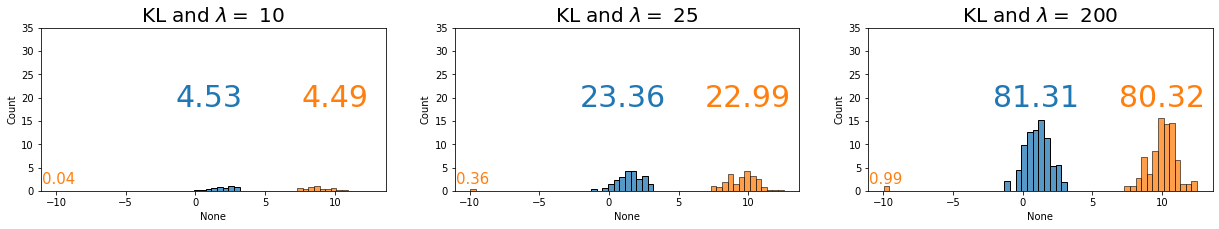

In [8]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, len(lam), wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
    pl.text(1,20, wKL1[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
    pl.text(10,20, wKL2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
    pl.text(-9.8, 2.5, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 15)
    pl.ylim(0,35)
    pl.title("KL and $\lambda =$ %i"%lam[i],size=20)

In [9]:
lam=[2,3,5]
Kx,Ky=kernel(X[:,None],Y[:,None],sigma=1,k="gaussian")
P_MMD=[]
pi1_MMD=[]
pi2_MMD=[]
for l in lam:
    #P=UOT_MMD(a,b,C,lam=l,Kx=Kx,Ky=Ky,solver="CLARABEL",regul=1e0)
    u,v,G=sinkhorn(a,b,C,lam=l,eps=1e0,numiter=500,pen="kkl",
                      Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(torch.sum(P))
    P_MMD+=[P]
    pi1_MMD+=[abs((P)@torch.ones(m))]
    pi2_MMD+=[abs((P.T)@torch.ones(n))]    

tensor(83.4082)
tensor(88.2760)
tensor(92.5254)


In [10]:
wMMD1=[]
wMMD2=[]
wMMD3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_MMD[i]),torch.sum(pi2_MMD[i][:99]),torch.sum(pi2_MMD[i][99:]))
    wMMD1+=[np.round(torch.sum(pi1_MMD[i]).numpy(),2)]
    wMMD2+=[np.round(torch.sum(pi2_MMD[i][:99]).numpy(),2)]
    wMMD3+=[np.round(torch.sum(pi2_MMD[i][99:]).numpy(),2)]

tensor(83.4082) tensor(83.4065) tensor(0.0017)
tensor(88.2760) tensor(88.2620) tensor(0.0140)
tensor(92.5254) tensor(92.4374) tensor(0.0881)


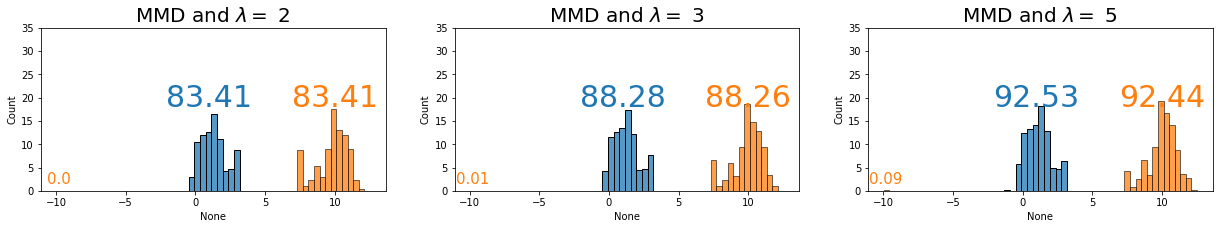

In [11]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, 3, wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[i//3, i%3])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_MMD[i],kde_kws=dict(bw_adjust=2))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_MMD[i],kde_kws=dict(bw_adjust=2))
    pl.text(1,20, wMMD1[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
    pl.text(10,20, wMMD2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
    pl.text(-9.8, 2.5, wMMD3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 15)
    pl.ylim(0,35)
    pl.title("MMD and $\lambda =$ %i"%lam[i],size=20)

# Case 2: Noise

100 100


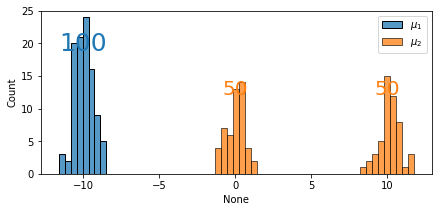

In [12]:
np.random.seed(1)
X,Y=make_data_1d("noise",50)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
pl.figure(figsize=(7,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",weights=a,binwidth=.4,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",weights=b,binwidth=.4,kde_kws=dict(bw_adjust=.5),stat="count")
pl.text(-10,20,100 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,13, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(10, 13, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,25)
pl.legend()

In [13]:
lam=[60,150,500]
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(31.4507)
tensor(54.5153)
tensor(79.8823)


/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [14]:
wKL1=[]
wKL2=[]
wKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KL[i]),torch.sum(pi2_KL[i][:50]),torch.sum(pi2_KL[i][50:]))
    wKL1+=[np.round(torch.sum(pi1_KL[i]).numpy(),2)]
    wKL2+=[np.round(torch.sum(pi2_KL[i][:50]).numpy(),2)]
    wKL3+=[np.round(torch.sum(pi2_KL[i][50:]).numpy(),2)]

tensor(31.4507) tensor(31.1156) tensor(0.3351)
tensor(54.5153) tensor(47.5336) tensor(6.9818)
tensor(79.8823) tensor(51.5496) tensor(28.3328)


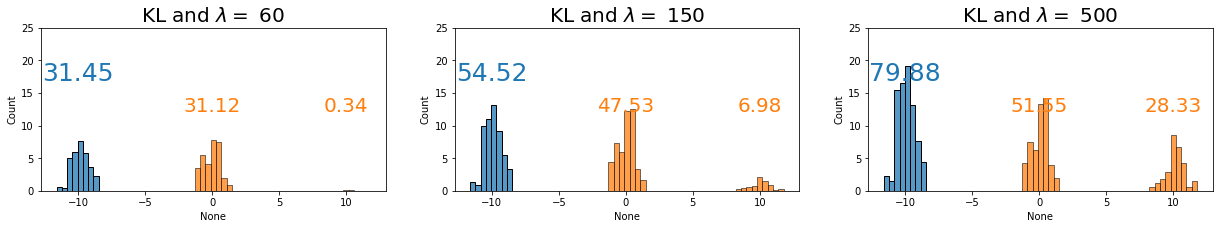

In [15]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, len(lam), wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
    pl.text(-10,18,wKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(0,13, wKL2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(10, 13, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,25)
    pl.title("KL and $\lambda =$ %i"%lam[i],size=20)

In [16]:
lam=[1,4,5]
Cx,Cy=ot.dist(X[:,None],X[:,None]),ot.dist(Y[:,None],Y[:,None])
P_W=[]
pi1_W=[]
pi2_W=[]
for l in lam:
    P=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_W+=[P]
    pi1_W+=[abs(P)@torch.ones(m)]
    pi2_W+=[abs(P.T)@torch.ones(n)]    

tensor(100.0000)
tensor(100.)
tensor(100.)


In [17]:
wW1=[]
wW2=[]
wW3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_W[i]),torch.sum(pi2_W[i][:50]),torch.sum(pi2_W[i][50:]))
    wW1+=[np.round(torch.sum(pi1_W[i]).numpy(),2)]
    wW2+=[np.round(torch.sum(pi2_W[i][:50]).numpy(),2)]
    wW3+=[np.round(torch.sum(pi2_W[i][50:]).numpy(),2)]

tensor(100.) tensor(100.0000) tensor(6.0402e-07)
tensor(100.) tensor(50.) tensor(50.)
tensor(100.) tensor(50.) tensor(50.)


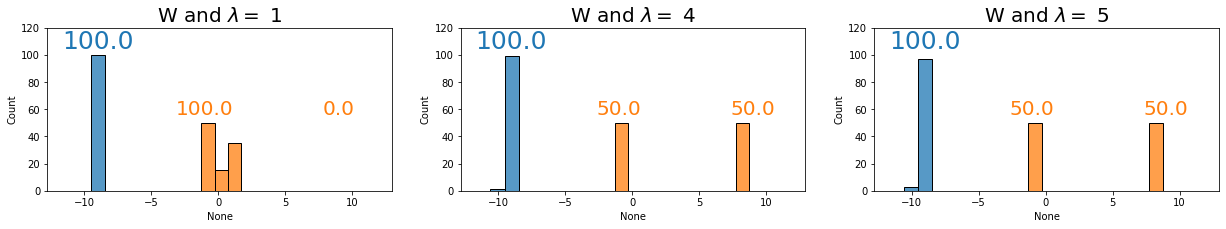

In [18]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, 3, wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[i//3, i%3])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=1,weights=pi1_W[i],kde_kws=dict(bw_adjust=2))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=1,weights=pi2_W[i],kde_kws=dict(bw_adjust=2))
    pl.text(-9,110,wW1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(-1,60, wW2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(9, 60, wW3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,120)
    pl.title("W and $\lambda =$ %i"%lam[i],size=20)

# Case 3: death birth

80 110


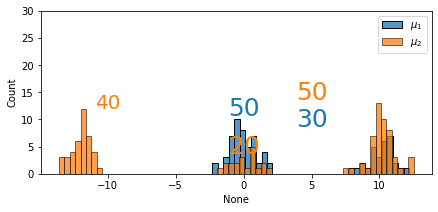

In [19]:
np.random.seed(1)
n0=10
X,Y=make_data_1d("death_birth",n0)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
pl.figure(figsize=(7,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=.1))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=.1))
pl.text(0,12,50 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(5,10,30 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(-10, 13, 40,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(0,5,20 ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(5,15,50 ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.ylim(0,30)
pl.legend()

In [20]:
a.shape,b.shape

(torch.Size([80]), torch.Size([110]))

In [21]:
print(1,torch.sum(a[:5*n0]),torch.sum(a[5*n0:]))
print(2,torch.sum(b[:4*n0]),torch.sum(b[4*n0:6*n0]),torch.sum(b[6*n0:]))

1 tensor(50.) tensor(30.)
2 tensor(40.) tensor(20.) tensor(50.)


In [22]:
lam=[30,150,200]#,100,120,500]
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(71.5114)
tensor(82.2649)
tensor(84.4589)


In [23]:
wKL1=[]
wKL2=[]
wKL3=[]
wKL4=[]
wKL5=[]
for i in range(len(lam)):
    print(1,torch.sum(pi1_KL[i][:5*n0]),torch.sum(pi1_KL[i][5*n0:]))
    print(2,torch.sum(pi2_KL[i][:4*n0]),torch.sum(pi2_KL[i][4*n0:6*n0]),torch.sum(pi2_KL[i][6*n0:]))
    wKL1+=[int(np.round(torch.sum(pi1_KL[i][:5*n0]).numpy()))]
    wKL2+=[int(np.round(torch.sum(pi1_KL[i][5*n0:]).numpy()))]
    wKL3+=[int(np.round(torch.sum(pi2_KL[i][:4*n0]).numpy()))]
    wKL4+=[int(np.round(torch.sum(pi2_KL[i][4*n0:6*n0]).numpy()))]
    wKL5+=[int(np.round(torch.sum(pi2_KL[i][6*n0:]).numpy()))]

1 tensor(32.8189) tensor(38.6925)
2 tensor(1.8806) tensor(30.9384) tensor(38.6925)
1 tensor(45.0282) tensor(37.2367)
2 tensor(18.8577) tensor(22.9655) tensor(40.4417)
1 tensor(47.7344) tensor(36.7245)
2 tensor(21.8448) tensor(21.6098) tensor(41.0044)


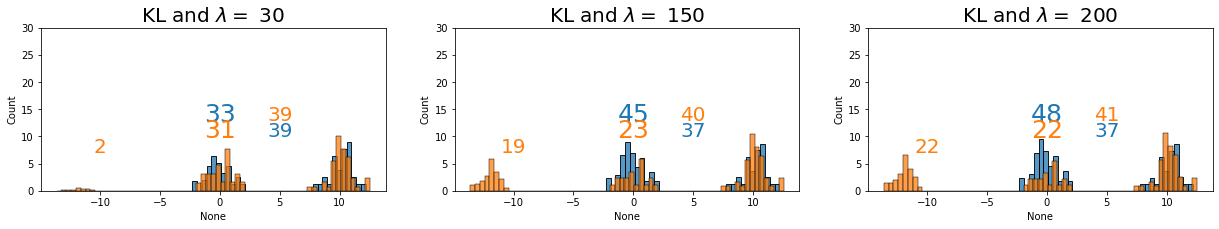

In [24]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, 3, wspace=.2,hspace=1)
for i in range(len(lam)):
    pl.subplot(grid[i//3, i%3])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
    pl.text(0,14,wKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(5,11, wKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(-10, 8, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(0,11,wKL4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(5,14, wKL5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
    pl.ylim(0,30)

In [53]:
lam=[1,6,12]#,100,120,500]
Kx,Ky=kernel(X[:,None],Y[:,None],sigma=1,k="gaussian")
P_MMD=[]
pi1_MMD=[]
pi2_MMD=[]
for l in lam:
    #P=UOT_MMD(a,b,C,lam=l,Kx=Kx,Ky=Ky,solver="CLARABEL",regul=1e-2)
    u,v,G=logsinkhorn(a,b,C,lam=l,eps=2e0,numiter=500,pen="kkl",
                      Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(torch.sum(P))
    P_MMD+=[P]
    pi1_MMD+=[abs(P)@torch.ones(m)]
    pi2_MMD+=[abs(P.T)@torch.ones(n)]    

tensor(96.8804)
tensor(102.1183)
tensor(102.8209)


In [54]:
wMMD1=[]
wMMD2=[]
wMMD3=[]
wMMD4=[]
wMMD5=[]
for i in range(len(lam)):
    print(1,torch.sum(pi1_MMD[i][:5*n0]),torch.sum(pi1_MMD[i][5*n0:]))
    print(2,torch.sum(pi2_MMD[i][:4*n0]),torch.sum(pi2_MMD[i][4*n0:6*n0]),torch.sum(pi2_MMD[i][6*n0:]))
    wMMD1+=[int(np.round(torch.sum(pi1_MMD[i][:5*n0]).numpy()))]
    wMMD2+=[int(np.round(torch.sum(pi1_MMD[i][5*n0:]).numpy()))]
    wMMD3+=[int(np.round(torch.sum(pi2_MMD[i][:4*n0]).numpy()))]
    wMMD4+=[int(np.round(torch.sum(pi2_MMD[i][4*n0:6*n0]).numpy()))]
    wMMD5+=[int(np.round(torch.sum(pi2_MMD[i][6*n0:]).numpy()))]

1 tensor(49.6132) tensor(47.2672)
2 tensor(6.1346) tensor(43.4787) tensor(47.2672)
1 tensor(57.9857) tensor(44.1326)
2 tensor(26.9582) tensor(30.7530) tensor(44.4071)
1 tensor(59.1216) tensor(43.6992)
2 tensor(34.4213) tensor(23.3576) tensor(45.0420)


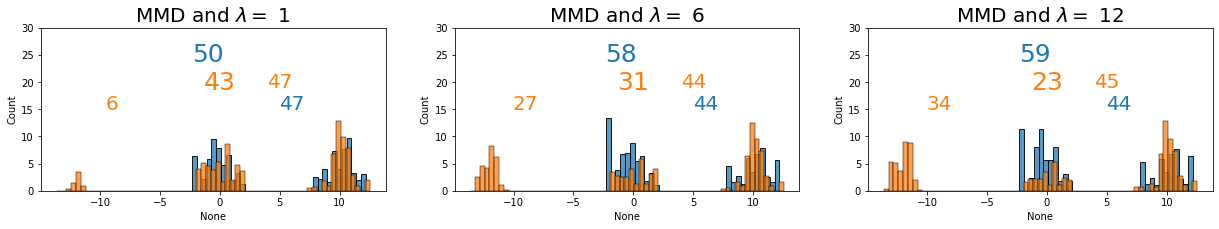

In [55]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, 3, wspace=.2,hspace=1)
for i in range(len(lam)):
    pl.subplot(grid[i//3, i%3])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_MMD[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_MMD[i],kde_kws=dict(bw_adjust=.5))
    pl.text(-1,25,wMMD1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(6,16, wMMD2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(-9, 16, wMMD3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(0,20,wMMD4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(5,20, wMMD5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,30)
    pl.title("MMD and $\lambda =$ %i"%lam[i],size=20)

# Case 4: No renormalization (distance)

200 100


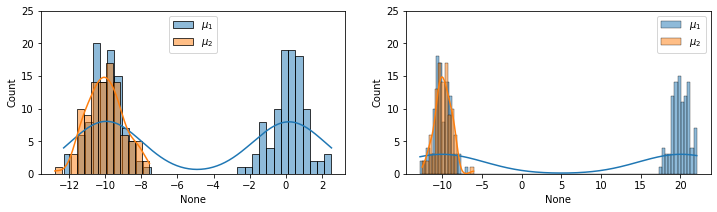

In [82]:
np.random.seed(1)
X1,Y1=make_data_1d("renormalization1",5)
X2,Y2=make_data_1d("renormalization2",5)
n,m=X1.shape[0],Y1.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C1=ot.dist(X1[:,None],Y1[:,None])
C2=ot.dist(X2[:,None],Y2[:,None])

pl.figure(figsize=(12,3))
pl.subplot(1,2,1)
sns.histplot(x=X1, kde=True,label="$\mu_1$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=1))
sns.histplot(x=Y1, kde=True,label="$\mu_2$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=1))
pl.ylim(0,25)
pl.legend()
pl.subplot(1,2,2)
sns.histplot(x=X2, kde=True,label="$\mu_1$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=1))
sns.histplot(x=Y2, kde=True,label="$\mu_2$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=1))
pl.ylim(0,25)
pl.legend()


In [83]:
lam1=[5]
P_KL1=[]
pi1_KL1=[]
pi2_KL1=[]
for l in lam1:
    P=UOT_KL(a,b,C1,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL1+=[P]
    pi1_KL1+=[(P)@torch.ones(m)]
    pi2_KL1+=[(P.T)@torch.ones(n)]   

tensor(99.7436)


In [84]:
lam2=[8]
P_KL2=[]
pi1_KL2=[]
pi2_KL2=[]
for l in lam2:
    P=UOT_KL(a,b,C2,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL2+=[P]
    pi1_KL2+=[abs(P)@torch.ones(m)]
    pi2_KL2+=[abs(P.T)@torch.ones(n)]   

tensor(99.7836)


Text(0.5, 1.0, 'KL and $\\lambda =$ 8')

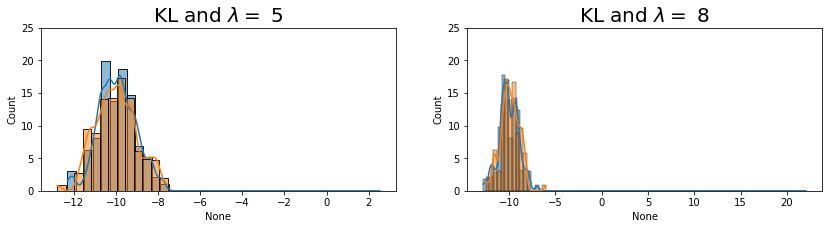

In [86]:
fig = pl.figure(figsize=(14,3))
pl.subplot(1,2,1)
sns.histplot(x=X1, kde=True,label="mu",binwidth=.4,weights=pi1_KL1[0],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y1, kde=True,label="nu",binwidth=.4,weights=pi2_KL1[0],kde_kws=dict(bw_adjust=.5))
pl.ylim(0,25)
pl.title("KL and $\lambda =$ %i"%lam1[0],size=20)
pl.subplot(1,2,2)
sns.histplot(x=X2, kde=True,label="mu",binwidth=.4,weights=pi1_KL2[0],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y2, kde=True,label="nu",binwidth=.4,weights=pi2_KL2[0],kde_kws=dict(bw_adjust=.5))
pl.ylim(0,25)
pl.title("KL and $\lambda =$ %i"%lam2[0],size=20)

In [87]:
for i in range(len(lam1)):
    print(1,torch.sum(pi1_KL1[i][:100]),torch.sum(pi1_KL1[i][100:]),end=" ")
    print(2,torch.sum(pi2_KL1[i]))
for i in range(len(lam2)):
    print(1,torch.sum(pi1_KL2[i][:100]),torch.sum(pi1_KL2[i][100:]),end=" ")
    print(2,torch.sum(pi2_KL2[i]))

1 tensor(99.7283) tensor(0.0153) 2 tensor(99.7436)
1 tensor(99.7836) tensor(5.9988e-06) 2 tensor(99.7836)


In [88]:
lam1=[.6]
Kx1,Ky1=kernel(X1[:,None],Y1[:,None],sigma=10,k="gaussian")
P_MMD1=[]
pi1_MMD1=[]
pi2_MMD1=[]
for l in lam1:
    P=UOT_MMD(a,b,C1,lam=l,Kx=Kx1,Ky=Ky1,solver="CLARABEL",regul=1e-2)
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_MMD1+=[P]
    pi1_MMD1+=[abs((P)@torch.ones(m))]
    pi2_MMD1+=[abs((P.T)@torch.ones(n))]    

tensor(133.6359)


In [121]:
lam2=[3]
Kx2,Ky2=kernel(X2[:,None],Y2[:,None],sigma=10,k="gaussian")
P_MMD2=[]
pi1_MMD2=[]
pi2_MMD2=[]
for l in lam2:
    P=UOT_MMD(a,b,C2,lam=l,Kx=Kx2,Ky=Ky2,solver="CLARABEL",regul=1e-2)
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_MMD2+=[P]
    pi1_MMD2+=[abs((P)@torch.ones(m))]
    pi2_MMD2+=[abs((P.T)@torch.ones(n))]  

tensor(102.4933)


Text(0.5, 1.0, 'MMD and $\\lambda =$ 3')

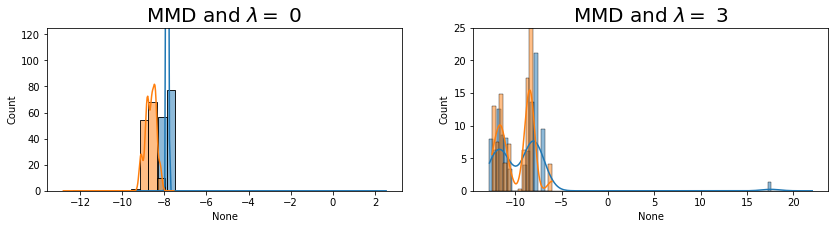

In [123]:
fig = pl.figure(figsize=(14,3))
pl.subplot(1,2,1)
sns.histplot(x=X1, kde=True,label="mu",binwidth=.4,weights=pi1_MMD1[0],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y1, kde=True,label="nu",binwidth=.4,weights=pi2_MMD1[0],kde_kws=dict(bw_adjust=.5))
pl.ylim(0,125)
pl.title("MMD and $\lambda =$ %i"%lam1[0],size=20)
pl.subplot(1,2,2)
sns.histplot(x=X2, kde=True,label="mu",binwidth=.4,weights=pi1_MMD2[i],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y2, kde=True,label="nu",binwidth=.4,weights=pi2_MMD2[i],kde_kws=dict(bw_adjust=.5))
pl.ylim(0,25)
pl.title("MMD and $\lambda =$ %i"%lam2[0],size=20)

In [124]:
for i in range(len(lam1)):
    print(1,torch.sum(pi1_MMD1[i][:100]),torch.sum(pi1_MMD1[i][100:]),end=" ")
    print(2,torch.sum(pi2_MMD1[i]))
for i in range(len(lam2)):
    print(1,torch.sum(pi1_MMD2[i][:100]),torch.sum(pi1_MMD2[i][100:]),end=" ")
    print(2,torch.sum(pi2_MMD2[i]))

1 tensor(133.6360) tensor(2.8415e-08) 2 tensor(133.6360)
1 tensor(101.1231) tensor(1.3702) 2 tensor(102.4933)


In [415]:
"""df = pd.DataFrame(data = [torch.cat((X,Y)).numpy(),n*["$\pi^1$"]+m*["$\pi^2$"]],index=["data","Legend"]).T
pl.figure(figsize=(6,3))
sns.kdeplot(df,x="data",hue="Legend",fill=True,common_norm=False,bw_adjust=.5)

fig = pl.figure(figsize=(18,6))
grid = pl.GridSpec(2, len(lam), wspace=.2, hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[0, i])
    sns.kdeplot(df,x="data",hue="Legend",weights=torch.cat((pi1_KL[i],pi2_KL[i])),fill=True,bw_adjust=.5)
    pl.title("$\lambda =$ %i"%lam[i],size=20)
    pl.subplot(grid[1, i])
    sns.kdeplot(df,x="data",hue="Legend",weights=torch.cat((pi1_UOT[i],pi2_UOT[i])),fill=True,bw_adjust=.5)
    pl.title("$\lambda =$ %i"%lam[i],size=20)"""

'df = pd.DataFrame(data = [torch.cat((X,Y)).numpy(),n*["$\\pi^1$"]+m*["$\\pi^2$"]],index=["data","Legend"]).T\npl.figure(figsize=(6,3))\nsns.kdeplot(df,x="data",hue="Legend",fill=True,common_norm=False,bw_adjust=.5)\n\nfig = pl.figure(figsize=(18,6))\ngrid = pl.GridSpec(2, len(lam), wspace=.2, hspace=0.5)\nfor i in range(len(lam)):\n    pl.subplot(grid[0, i])\n    sns.kdeplot(df,x="data",hue="Legend",weights=torch.cat((pi1_KL[i],pi2_KL[i])),fill=True,bw_adjust=.5)\n    pl.title("$\\lambda =$ %i"%lam[i],size=20)\n    pl.subplot(grid[1, i])\n    sns.kdeplot(df,x="data",hue="Legend",weights=torch.cat((pi1_UOT[i],pi2_UOT[i])),fill=True,bw_adjust=.5)\n    pl.title("$\\lambda =$ %i"%lam[i],size=20)'